In [37]:
import numpy as np
import pandas as pd
import json
import math

In [38]:
# Libraries that we cannot import for trading
import collections
import matplotlib.pyplot as plt
import re

import seaborn as sns
from IPython.display import display

In [39]:
SYMBOLS = ['PICNIC_BASKET','DIP','BAGUETTE','UKULELE']

# DATA LOADING

In [26]:
def split_data_by_symbol(df):
    markets = dict()
    df_grouped = df.groupby("symbol")
    symbols = list(df_grouped.groups.keys())
    for s in SYMBOLS:
        if s in df_grouped.groups:
            markets[s] = df_grouped.get_group(s).reset_index(drop=True)
    return markets

def load_hist_quote_data(files):
    md = [pd.read_csv(f,sep=';') for f in files]
    md = pd.concat(md, ignore_index=True)
    md.drop(columns=['profit_and_loss'], inplace=True)
    rename_columns = {'product':'symbol', 'bid_price_1': 'bid', 'ask_price_1': 'ask', 
                      'bid_volume_1':'bid_sz', 'ask_volume_1': 'ask_sz', 
                      'bid_price_2':'bid_2','bid_volume_2':'bid_sz_2','ask_price_2':'ask_2','ask_volume_2':'ask_sz_2',
                      'bid_price_3':'bid_3','bid_volume_3':'bid_sz_3','ask_price_3':'ask_3','ask_volume_3':'ask_sz_3'}
    md.rename(columns=rename_columns, inplace=True)
    for i in [4, 5]:
        for col in ['bid','ask']:
            md[f'{col}_{i}'] = np.nan
            md[f'{col}_sz_{i}'] = np.nan

    md['timestamp'] = md['timestamp'] + 1000000*md['day'] - 1000000*(md['day'].min())
    markets = split_data_by_symbol(md)
    symbols = list(markets.keys())
    return markets


def load_hist_trade_data(files, hist_days):
    md = [pd.read_csv(f,sep=';') for f in files]
    for i in range(len(hist_days)):
        md[i]['day'] = hist_days[i]
    md = pd.concat(md, ignore_index=True)
    md.drop(columns=['buyer', 'seller'], inplace=True)
    md = md[md.price > 0].copy()
    md['timestamp'] = md['timestamp'] + 1000000*md['day'] - 1000000*(md['day'].min())
    
    markets = split_data_by_symbol(md)
    symbols = list(markets.keys())
    return markets

def augment_trade_data(trades):
    """ Making a guess to the sides of the trades based distance to mid price of previous quote
    Experimental - NOT SURE IF THIS IS GOING TO BE HELPFUL
    """
    bid_dist = trades['price'] - trades['bid']
    ask_dist = trades['ask'] - trades['price']
    trades['side'] = np.sign(bid_dist-ask_dist)
    return

def combine_hist_quote_trades(hist_quotes, hist_trades):
    """ Join data frames together
    """
    for sym in SYMBOLS:
        if not sym in hist_trades:
            continue
        quotes = hist_quotes[sym]
        trades = hist_trades[sym]
        # Join quote data to trades
        trades = trades.merge(quotes, how='left', on=['symbol','day','timestamp'])
        trades['notional'] = trades['price']*trades['quantity']

        augment_trade_data(trades)
        trades['buy_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == 1 else 0, axis=1)
        trades['sell_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == -1 else 0, axis=1)
        trades['grey_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == 0 else 0, axis=1)
        
        # Summarize state by state trade data
        trades_grp = trades.groupby(['symbol','day','timestamp']).agg({
            'quantity':'sum', 'notional':'sum', 'buy_vol':'sum', 'sell_vol':'sum','grey_vol':'sum'})
        
        trades_grp['vwap'] = trades_grp['notional']/trades_grp['quantity']
        trades_grp['trades'] = trades.groupby(['symbol','day','timestamp']).size()
        trades_grp = trades_grp.rename(columns={'quantity':'volume'})
        
        # Join trade data to quote
        quotes = quotes.merge(trades_grp.reset_index(), how='left')
        for col in ['volume', 'notional','trades', 'buy_vol','sell_vol','grey_vol']:
            quotes[col].fillna(0, inplace=True)
        quotes['vwap'].fillna(method='ffill',inplace=True)
        quotes.loc[quotes.vwap.isna(), 'vwap'] = quotes.loc[quotes.vwap.isna(), 'mid_price']
        
        # Update
        hist_quotes[sym] = quotes
        hist_trades[sym] = trades.copy()
    
    return hist_quotes, hist_trades

def load_hist_data(quote_files, trade_files, hist_days):
    hist_quotes = load_hist_quote_data(quote_files)
    hist_trades = load_hist_trade_data(trade_files, hist_days)
    
    hist_quotes, hist_trades = combine_hist_quote_trades(hist_quotes, hist_trades)
    return hist_quotes, hist_trades

In [7]:
def quote_levels_feature(quote):
    quote['bid_levels'] = 1
    quote['ask_levels'] = 1
    
    for i in range(2,6):
        quote.loc[quote[f'bid_{i}'].notna(), 'bid_levels'] += 1
        quote.loc[quote[f'ask_{i}'].notna(), 'ask_levels'] += 1
    
    return

def quote_weighted_px_full(quote, levels=5):
    notional = quote.bid_sz*quote.bid + quote.ask_sz*quote.ask
    size = quote.bid_sz + quote.ask_sz
    for i in range(2, min(quote['bid_levels'], levels)+1):
        notional += quote[f'bid_{i}']*quote[f'bid_sz_{i}']
        size += quote[f'bid_sz_{i}']
    for i in range(2, min(quote['ask_levels'], levels)+1):
        notional += quote[f'ask_{i}']*quote[f'ask_sz_{i}']
        size += quote[f'ask_sz_{i}']
    
    return notional/size


def quote_weighted_px_square(quote, levels=5):
    notional, size = 0, 0
    for x in ['bid','ask']:
        notional += np.square(quote[f'{x}_sz'])*quote[x]
        size += np.square(quote[f'{x}_sz'])
   
        for i in range(2, min(quote[f'{x}_levels'], levels)+1):
            notional += quote[f'{x}_{i}']*np.square(quote[f'{x}_sz_{i}'])
            size += np.square(quote[f'{x}_sz_{i}'])
    
    return notional/size

def quote_weighted_px_skip_top(quote, levels=5):
    notional, size = 0, 0
    
    if quote['bid_sz'] >= 5:
        notional += quote.bid_sz*quote.bid
        size += quote.bid_sz
    if quote['ask_sz'] >= 5:
        notional += quote.ask_sz*quote.ask
        size += quote.ask_sz

    for i in range(2, min(quote['bid_levels'], levels)+1):
        notional += quote[f'bid_{i}']*quote[f'bid_sz_{i}']
        size += quote[f'bid_sz_{i}']
    for i in range(2, min(quote['ask_levels'], levels)+1):
        notional += quote[f'ask_{i}']*quote[f'ask_sz_{i}']
        size += quote[f'ask_sz_{i}']
    
    return notional/size

In [34]:
MOVING_WINDOW_TIMES = [5, 10, 25, 50]
HIST_PX_TIMES = [1, 5]
# , 10, 20, 30, 50]
FUTURE_TIMES = [1, 2, 3, 4, 5, 10, 25, 50, 100, 200, 500]

def quote_preprocess(md):
    """ Pre-computing additional columns for analyzing quote
    """
    # md['mid_price'] = (md.ask_price_1 + md.bid_price_1)/2
    if 'bid_levels' not in md.columns:
        quote_levels_feature(md)
    md['spread'] = md.ask - md.bid
    md['return'] = md['mid_price']/md['mid_price'].iloc[0] # % change in price since the beginning
    
#     for t in MOVING_WINDOW_TIMES:
#         md[f'mid_px_mavg{t}'] = md['mid_price'].rolling(t, min_periods=0).mean()
#         md[f'mid_px_mavg{t}_norm'] = md[f'mid_px_mavg{t}']/md['mid_price']
#         md[f'px_norm_mavg{t}'] = md['return'].rolling(t, min_periods=0).mean()
        
    # quote weighted average price
    quote_sz = md.bid_sz + md.ask_sz
    md['quote_wgt_px_top'] = (md.bid_sz*md.bid + md.ask_sz*md.ask)/quote_sz
    md['fair_v1'] = md.apply(quote_weighted_px_full, axis=1)
    md['fair_v2'] = md['vwap']
    md['fair_v3'] = md.apply(quote_weighted_px_square, axis=1)
    
    for t in HIST_PX_TIMES:
        # Price move since the past
        md[f'px_move_{t}'] = md.mid_price-md.mid_price.shift(t)
        md[f'bid_move_{t}'] = md.bid-md.bid.shift(t)
        md[f'ask_move_{t}'] = md.ask-md.ask.shift(t)
        
        md[f'px_move_{t}'].fillna(0, inplace=True)
        md[f'bid_move_{t}'].fillna(0, inplace=True)
        md[f'ask_move_{t}'].fillna(0, inplace=True)
        
#         md[f'px_move_{t}_norm'] = md[f'px_move_{t}']/md['mid_price']
        
#         # log return
#         md[f'log_return_{t}'] = np.log(md.mid_price)-np.log(md.mid_price.shift(t))
#         md[f'log_return_{t}'].fillna(1, inplace=True)
#     md = md.copy()
    
    # Volume    
    for t in MOVING_WINDOW_TIMES:
        md[f'volume_{t}'] = md['volume'].rolling(t, min_periods=0).sum()
    if 'buy_vol' in md.columns:
        for t in MOVING_WINDOW_TIMES:
            md[f'buy_vol_{t}'] = md['buy_vol'].rolling(t, min_periods=0).sum()
            md[f'sell_vol_{t}'] = md['sell_vol'].rolling(t, min_periods=0).sum()
        md['volume_imb'] = md.buy_vol-md.sell_vol # Positive implies people are preparing for quote to move in
        
    md = md.copy()

    md['quote_imb'] = md.bid_sz/quote_sz
    md['levels_imb'] = md.bid_levels-md.ask_levels # Positive implies people are preparing for quote to move in
    
    ############# Future
    # Future prices
    for t in FUTURE_TIMES:
        # Future - present
        # Mid to mid, bid to mid, ask to mid
        md[f'fpx_{t}'] = md.mid_price.shift(-t).fillna(method='ffill') - md.mid_price
        md[f'fpx_bid_{t}'] = md.bid.shift(-t).fillna(method='ffill') - md.bid
        md[f'fpx_ask_{t}'] = md.ask.shift(-t).fillna(method='ffill') - md.ask
    for t in FUTURE_TIMES:
        md[f'fpx_move_{t}'] = np.sign(md[f'fpx_{t}'])
        md[f'fpx_bid_move_{t}'] = md[f'fpx_bid_{t}'] > 0
        md[f'fpx_ask_move_{t}'] = md[f'fpx_ask_{t}'] <= 0
    md['fvolume'] = md['volume'].shift(-1)
    for t in MOVING_WINDOW_TIMES:
        md[f'fvolume_{t}'] = md[f'volume_{t}'].shift(-t)
    md = md.copy()
        
    # Features
    md['total_bid_sz'] = md[['bid_sz','bid_sz_2','bid_sz_3','bid_sz_4','bid_sz_5']].sum(axis=1)
    md['max_bid_sz'] = md[['bid_sz','bid_sz_2','bid_sz_3','bid_sz_4','bid_sz_5']].max(axis=1)
    md['total_ask_sz'] = md[['ask_sz','ask_sz_2','ask_sz_3','ask_sz_4','ask_sz_5']].sum(axis=1)
    md['max_ask_sz'] = md[['ask_sz','ask_sz_2','ask_sz_3','ask_sz_4','ask_sz_5']].max(axis=1)
    
    md['bid_sz_mavg'] = md['bid_sz'].cumsum()/(1+md['timestamp']/100)
    md['ask_sz_mavg'] = md['ask_sz'].cumsum()/(1+md['timestamp']/100)
       
    for v in [1, 2, 3]:
        md[f'dist_fair_v{v}'] = md[f'fair_v{v}']-md['mid_price']
        md[f'dist_fair_v{v}_norm'] = md[f'dist_fair_v{v}']/md['mid_price']
        
        md[f'dist_fair_v{v}_bid'] = md[f'fair_v{v}']-md['bid'] # expected to be positive
        md[f'dist_fair_v{v}_ask'] = md[f'fair_v{v}']-md['ask'] # expected to be negative
        for t in HIST_PX_TIMES:
            md[f'fair_v{v}_move_{t}'] = md[f'fair_v{v}']-md[f'fair_v{v}'].shift(t)
            
#     md['bid_improve'] = md['bid'] > md['bid'].shift(1)
#     md['bid_revert'] = md['bid'] < md['bid'].shift(1)
#     md['ask_improve'] = md['ask'] < md['ask'].shift(1)
#     md['ask_revert'] = md['ask'] > md['ask'].shift(1)
    
    return md

In [9]:
def hist_data_summary(hist_quotes, hist_trades):
    for sym in SYMBOLS:
        print(sym)
        quote = hist_quotes[sym]
        quote_summary = quote.agg({
            'spread':['mean','std'], 'mid_price': ['mean','std'], 
            'fpx_move_10': ['mean','std'], 'fpx_move_1': ['mean','std'],
            'volume':['sum', 'mean'], 'trades':['sum', 'mean'],
            'bid_sz': 'mean', 'ask_sz':'mean', 
            'bid_levels':'mean', 'ask_levels':'mean',
            'bid_sz_2':'mean', 'ask_sz_2':'mean',
            'bid_sz_3':'mean', 'ask_sz_3':'mean',
        }).round(2)
        display(quote_summary)
        
fig_size = (6,3)

def plot_col_sym(md, sym, col):
    f, ax = plt.subplots(figsize=fig_size)
    ax.plot("timestamp", col, data=md)
    ax.set_xlabel("Time")
    ax.set_ylabel(col)
    ax.set_title(sym)
    plt.tight_layout()
    return

## Load

In [35]:
quote_files, trade_files = [], []

data_dir = 'hist_data/island-data-bottle-round-4/'
hist_days = [1, 2, 3]
quote_files += [f'{data_dir}prices_round_4_day_{i}.csv' for i in hist_days]
trade_files += [f'{data_dir}trades_round_4_day_{i}_nn.csv' for i in hist_days]

hist_quotes, hist_trades = load_hist_data(quote_files, trade_files, [1, 2, 3])
for sym in SYMBOLS:
    hist_quotes[sym] = quote_preprocess(hist_quotes[sym])

In [11]:
hist_data_summary(hist_quotes, hist_trades)

PICNIC_BASKET


,spread,mid_price,fpx_move_10,fpx_move_1,volume,trades,bid_sz,ask_sz,bid_levels,ask_levels,bid_sz_2,ask_sz_2,bid_sz_3,ask_sz_3
mean,11.34,74025.61,-0.0,0.00,0.18,0.06,6.02,6.05,2.68,2.67,16.88,16.94,22.03,22.09
std,2.50,243.52,1.0,0.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sum,NaN,NaN,NaN,NaN,5463.00,1758.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


DIP


,spread,mid_price,fpx_move_10,fpx_move_1,volume,trades,bid_sz,ask_sz,bid_levels,ask_levels,bid_sz_2,ask_sz_2,bid_sz_3,ask_sz_3
mean,1.68,7087.08,0.01,0.0,0.81,0.11,168.28,169.69,1.37,1.37,154.03,152.2,NaN,151.71
std,0.47,33.24,0.97,0.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sum,NaN,NaN,NaN,NaN,24200.00,3436.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


BAGUETTE


,spread,mid_price,fpx_move_10,fpx_move_1,volume,trades,bid_sz,ask_sz,bid_levels,ask_levels,bid_sz_2,ask_sz_2,bid_sz_3,ask_sz_3
mean,1.60,12216.08,0.02,0.00,0.55,0.1,73.15,73.86,1.62,1.62,75.56,75.05,NaN,73.65
std,0.49,155.85,0.98,0.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sum,NaN,NaN,NaN,NaN,16464.00,2873.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


UKULELE


,spread,mid_price,fpx_move_10,fpx_move_1,volume,trades,bid_sz,ask_sz,bid_levels,ask_levels,bid_sz_2,ask_sz_2,bid_sz_3,ask_sz_3
mean,1.41,20869.42,-0.02,-0.01,0.34,0.1,49.85,49.65,1.32,1.32,40.29,40.23,NaN,NaN
std,0.49,210.11,0.99,0.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sum,NaN,NaN,NaN,NaN,10196.00,3026.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Historical Quote Analysis

PICNIC_BASKET
DIP
BAGUETTE
UKULELE


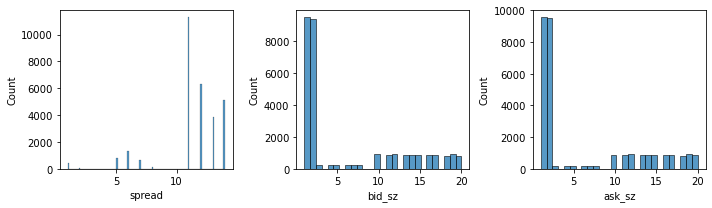

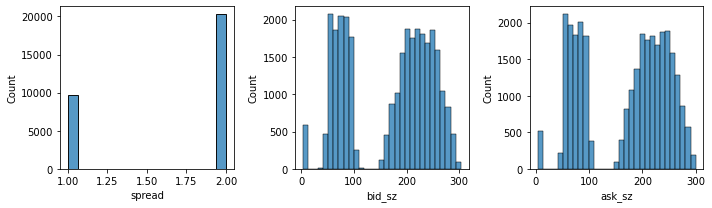

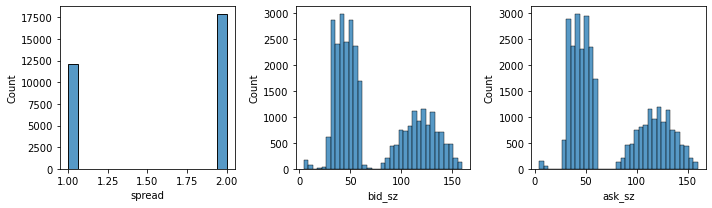

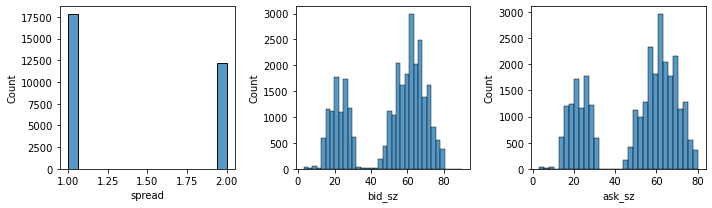

In [13]:
for sym in SYMBOLS:
    quote = hist_quotes[sym]
    print(sym)
    f, ax = plt.subplots(1, 3, figsize=(10,3))
    for i, col in enumerate(['spread','bid_sz','ask_sz']):
        sns.histplot(x=col, data=quote, ax=ax[i])
    plt.tight_layout()

PICNIC_BASKET
DIP
BAGUETTE
UKULELE


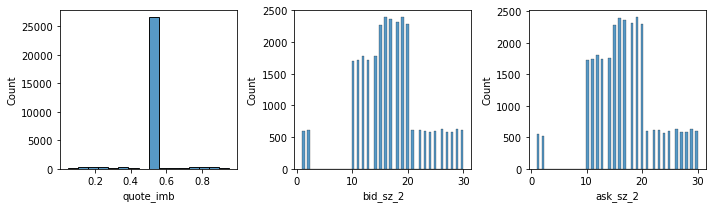

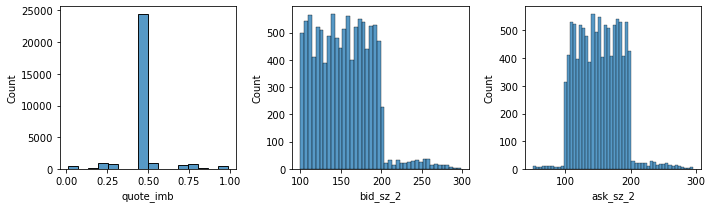

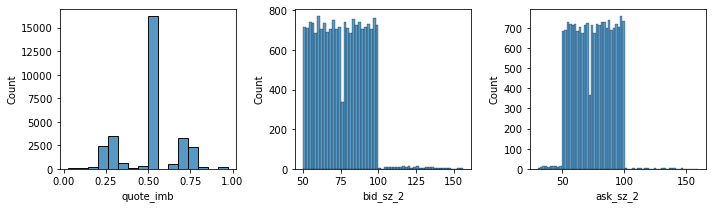

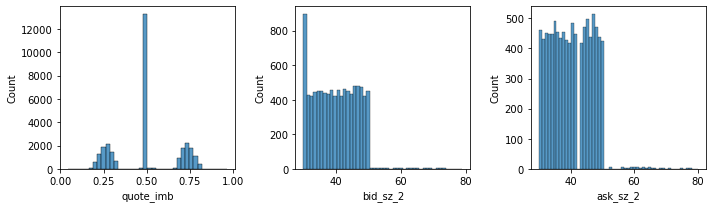

In [14]:
for sym in SYMBOLS:
    quote = hist_quotes[sym]
    print(sym)
    f, ax = plt.subplots(1, 3, figsize=(10,3))
    for i, col in enumerate(['quote_imb','bid_sz_2','ask_sz_2']):
        sns.histplot(x=col, data=quote, ax=ax[i])
    plt.tight_layout()

PICNIC_BASKET
DIP
BAGUETTE
UKULELE


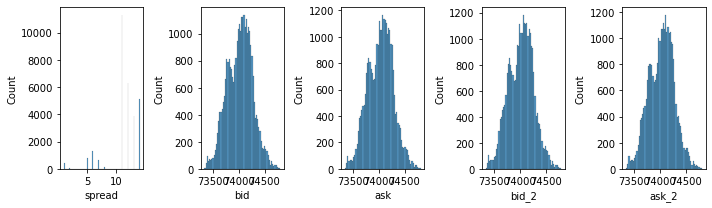

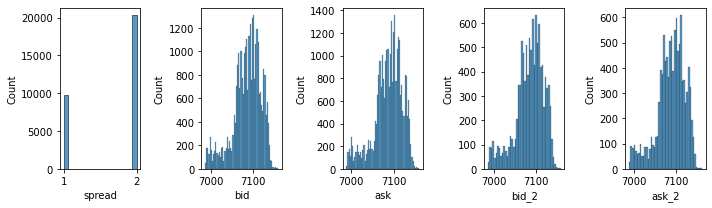

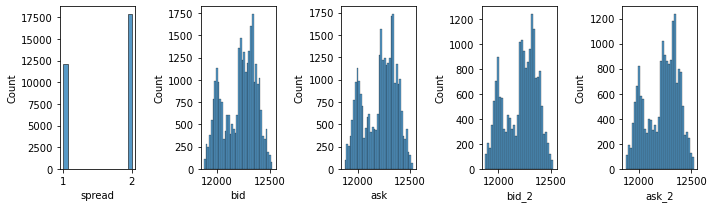

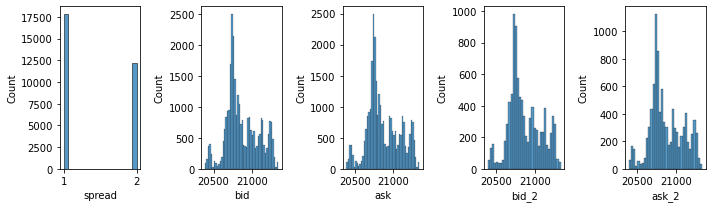

In [15]:
for sym in SYMBOLS:
    quote = hist_quotes[sym]
    print(sym)
    f, ax = plt.subplots(1, 5, figsize=(10,3))
    for i, col in enumerate(['spread','bid','ask', 'bid_2','ask_2']):
        sns.histplot(x=col, data=quote, ax=ax[i])
    plt.tight_layout()

PICNIC_BASKET
DIP
BAGUETTE
UKULELE


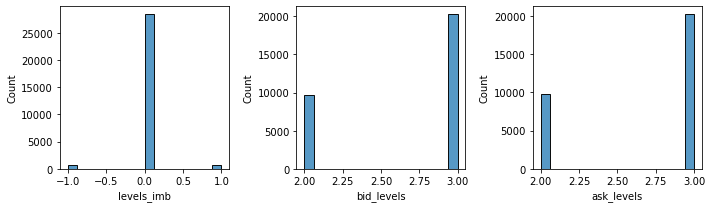

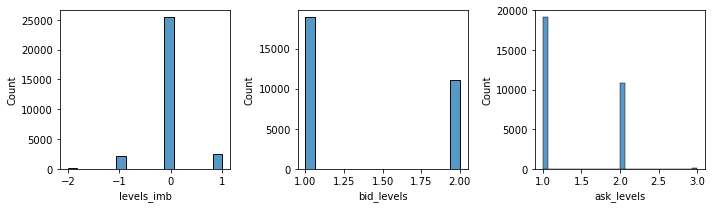

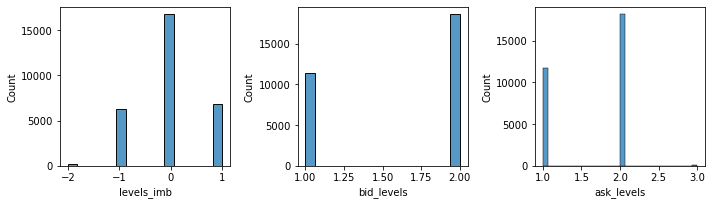

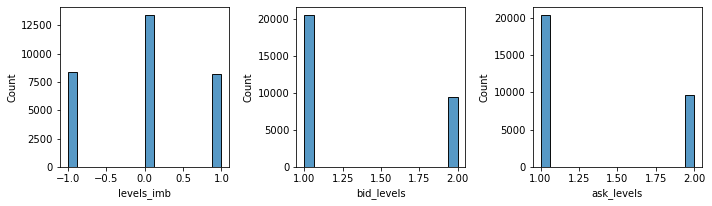

In [207]:
for sym in SYMBOLS:
    quote = hist_quotes[sym].copy()

    print(sym)
    f, ax = plt.subplots(1, 3, figsize=(10,3))
    for i, col in enumerate(['levels_imb', 'bid_levels', 'ask_levels']):
        sns.histplot(x=col, data=quote, ax=ax[i])
    plt.tight_layout()

In [209]:
quote = hist_quotes['PICNIC_BASKET'].copy()
quote['b_b2'] = quote['bid'] - quote['bid_2']
quote['a_a2'] = quote['ask_2'] - quote['ask']
quote['b_b3'] = quote['bid'] - quote['bid_3']
quote['a_a3'] = quote['ask_3'] - quote['ask']

In [211]:
quote['b_b3'].value_counts()

2.0     14365
3.0      4085
6.0       683
7.0       546
12.0      211
8.0       209
13.0      115
14.0       45
11.0       10
Name: b_b3, dtype: int64

PICNIC_BASKET
DIP
BAGUETTE
UKULELE


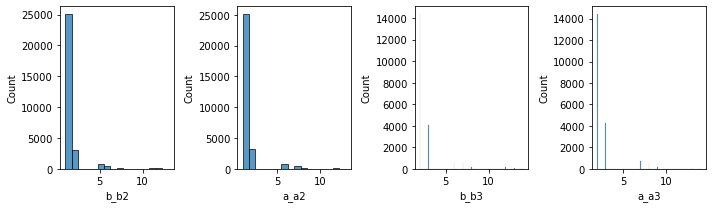

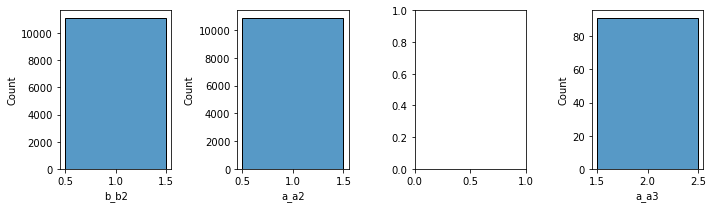

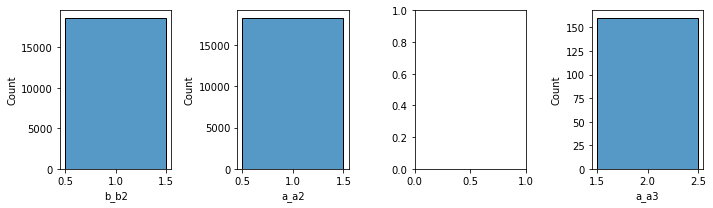

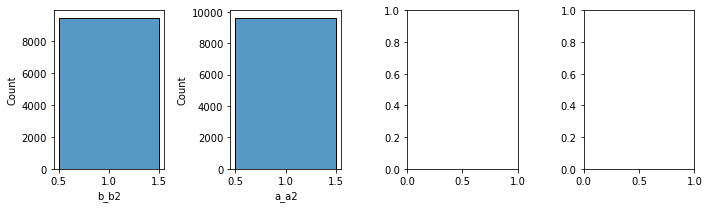

In [208]:
for sym in SYMBOLS:
    quote = hist_quotes[sym].copy()
    quote['b_b2'] = quote['bid'] - quote['bid_2']
    quote['a_a2'] = quote['ask_2'] - quote['ask']
    quote['b_b3'] = quote['bid'] - quote['bid_3']
    quote['a_a3'] = quote['ask_3'] - quote['ask']
    print(sym)
    f, ax = plt.subplots(1, 4, figsize=(10,3))
    for i, col in enumerate(['b_b2','a_a2','b_b3','a_a3']):
        sns.histplot(x=col, data=quote, ax=ax[i])
    plt.tight_layout()

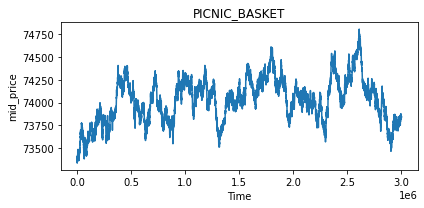

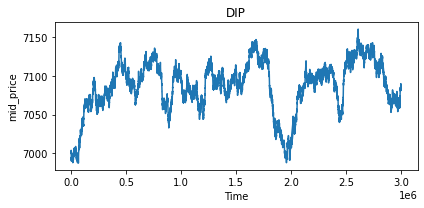

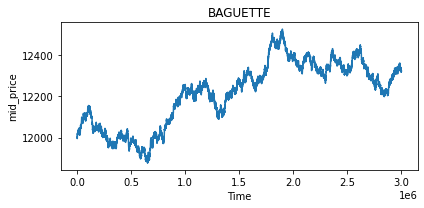

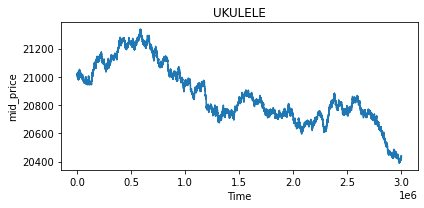

In [17]:
for sym in SYMBOLS:
    quote = hist_quotes[sym]
    plot_col_sym(quote, sym, 'mid_price')

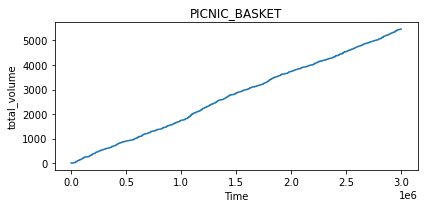

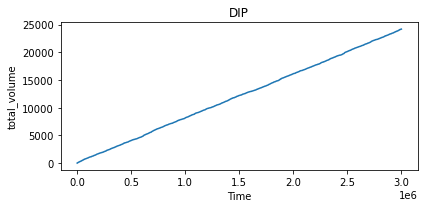

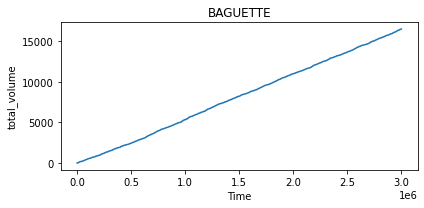

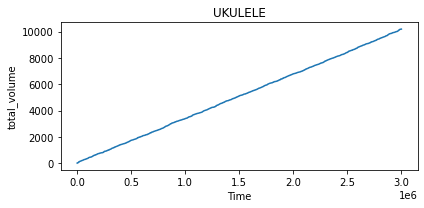

In [57]:
for sym in SYMBOLS:
    quote = hist_quotes[sym].copy()
    quote['total_volume'] = quote['volume'].cumsum()
    plot_col_sym(quote, sym, 'total_volume')

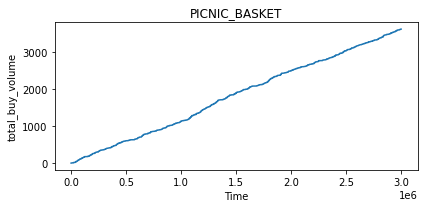

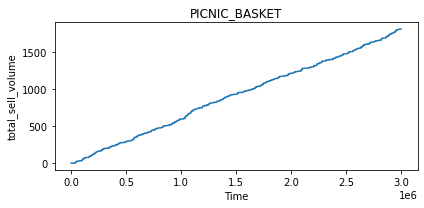

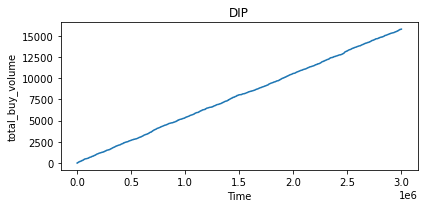

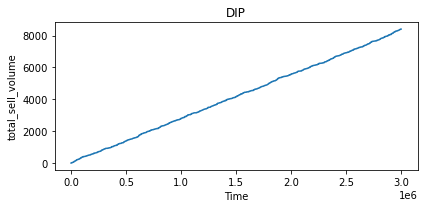

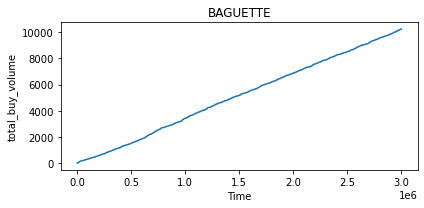

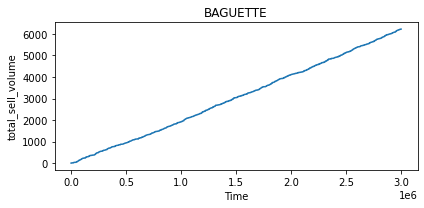

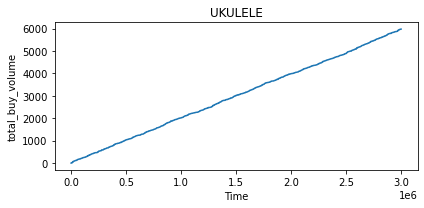

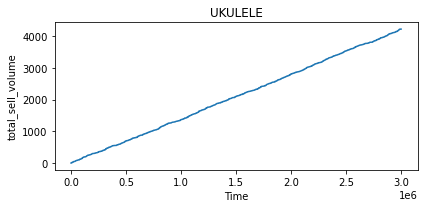

In [58]:
for sym in SYMBOLS:
    quote = hist_quotes[sym].copy()
    quote['total_buy_volume'] = quote['buy_vol'].cumsum()
    plot_col_sym(quote, sym, 'total_buy_volume')
    quote['total_sell_volume'] = quote['sell_vol'].cumsum()
    plot_col_sym(quote, sym, 'total_sell_volume')    

# Historical Trade Analysis

In [28]:
summ = []
for sym in SYMBOLS:
    trades = hist_trades[sym]
    summ.append(trades['quantity'].describe().rename(sym))
pd.concat(summ,axis=1).transpose()

,count,mean,std,min,25%,50%,75%,max
PICNIC_BASKET,1758.0,3.107509,2.467625,1.0,1.0,2.0,5.0,10.0
DIP,3436.0,7.043073,2.310764,3.0,5.0,7.0,9.0,12.0
BAGUETTE,2873.0,5.730595,1.844540,3.0,4.0,6.0,7.0,10.0
UKULELE,3026.0,3.369465,1.930267,1.0,2.0,3.0,5.0,11.0


In [29]:
summ = []
for sym in SYMBOLS:
    trades = hist_trades[sym]
    summ.append(trades.groupby('timestamp')['quantity'].sum().describe().rename(sym))
pd.concat(summ,axis=1).transpose()

,count,mean,std,min,25%,50%,75%,max
PICNIC_BASKET,1433.0,3.812282,2.792961,1.0,2.0,2.0,6.0,17.0
DIP,3355.0,7.213115,2.576823,3.0,5.0,7.0,9.0,21.0
BAGUETTE,2837.0,5.803313,1.983202,3.0,4.0,6.0,7.0,17.0
UKULELE,2994.0,3.405478,2.022076,1.0,2.0,3.0,5.0,15.0


PICNIC_BASKET
DIP
BAGUETTE
UKULELE


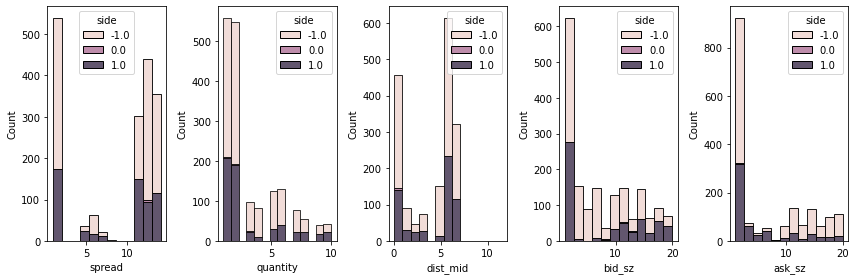

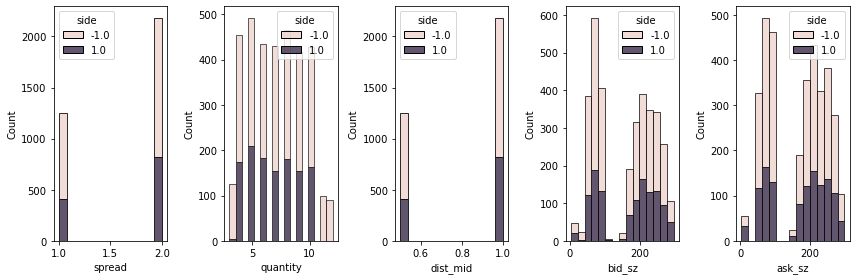

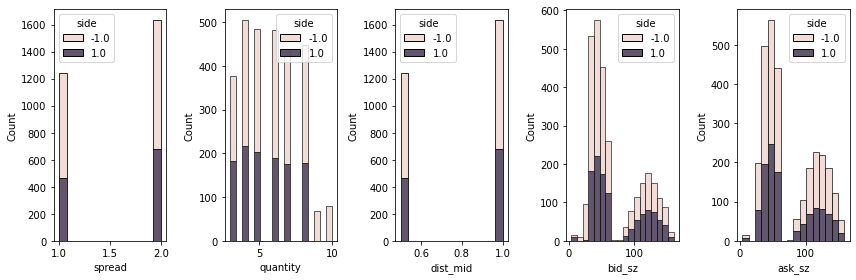

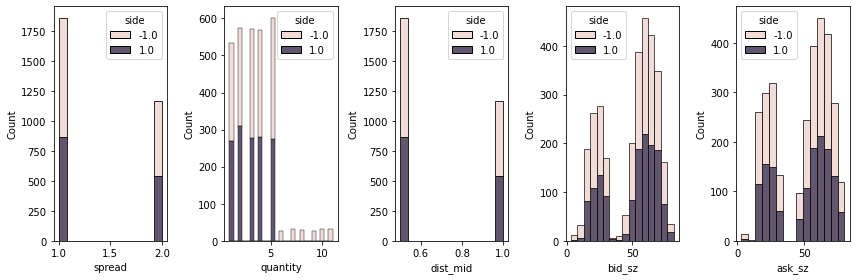

In [30]:
for sym in SYMBOLS:
    trades = hist_trades[sym]
    trades['spread'] = trades['ask']-trades['bid']
    trades['dist_mid'] = np.abs(trades['mid_price']-trades['price'])
    
    print(sym)
    f, ax = plt.subplots(1, 5, figsize=(12,4))
    for i, col in enumerate(['spread','quantity', 'dist_mid', 'bid_sz','ask_sz']):
        sns.histplot(x=col, data=trades, ax=ax[i], hue='side',multiple='stack')
    plt.tight_layout()

PICNIC_BASKET
DIP
BAGUETTE
UKULELE


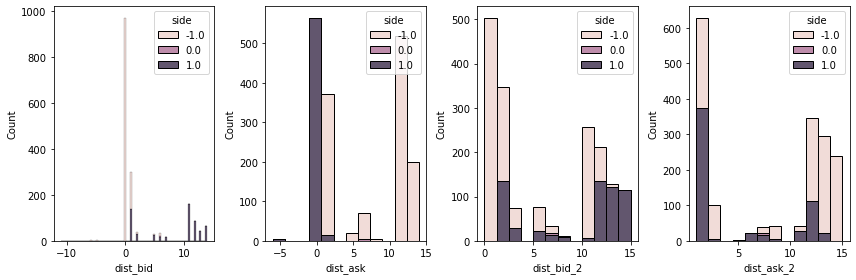

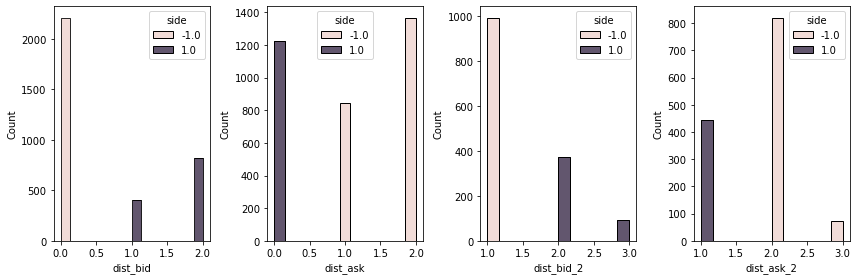

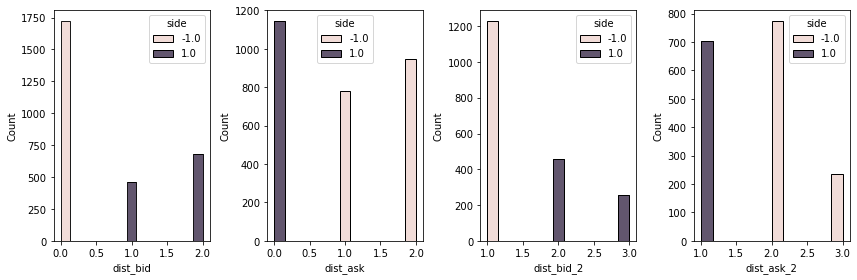

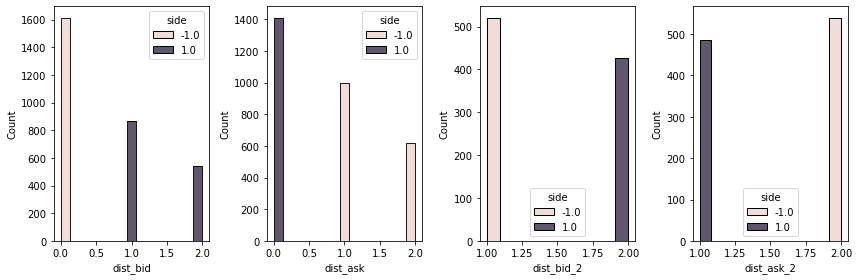

In [31]:
for sym in SYMBOLS:
    trades = hist_trades[sym]
    trades['dist_bid'] = trades['price']-trades['bid']
    trades['dist_ask'] = trades['ask']-trades['price']
    
    trades['dist_bid_2'] = trades['price']-trades['bid_2']
    trades['dist_ask_2'] = trades['ask_2']-trades['price']
    
    print(sym)
    f, ax = plt.subplots(1, 4, figsize=(12,4))
    for i, col in enumerate(['dist_bid','dist_ask','dist_bid_2','dist_ask_2']):
        sns.histplot(x=col, data=trades, ax=ax[i], hue='side',multiple='stack')
    plt.tight_layout()

# Symbol Specific Correlation Analysis

In [32]:
mid_labels = []
bid_labels = []
ask_labels = []
px_delta_cols = []

for t in FUTURE_TIMES:
    px_delta_cols.append(f'fpx_{t}')
    mid_labels.append(f'fpx_move_{t}')
    bid_labels.append(f'fpx_bid_move_{t}')
    ask_labels.append(f'fpx_ask_move_{t}')

In [36]:
for sym in SYMBOLS:
    sub_data = hist_quotes[sym].copy()
    # sub_data = sub_data.loc[np.abs(sub_data.time_to_mid_day) < 2000]
    print("{} {} {} {:.2f}%".format(sym, len(hist_quotes[sym].copy()), len(sub_data), 100*len(sub_data)/len(hist_quotes[sym])))
    corr = sub_data[['quote_imb', 'levels_imb', 'dist_fair_v1', 'px_move_1'] + mid_labels + px_delta_cols].corr()
    display(corr.style.background_gradient(cmap='coolwarm').format(precision=3))

PICNIC_BASKET 30000 30000 100.00%


,quote_imb,levels_imb,dist_fair_v1,px_move_1,fpx_move_1,fpx_move_2,fpx_move_3,fpx_move_4,fpx_move_5,fpx_move_10,fpx_move_25,fpx_move_50,fpx_move_100,fpx_move_200,fpx_move_500,fpx_1,fpx_2,fpx_3,fpx_4,fpx_5,fpx_10,fpx_25,fpx_50,fpx_100,fpx_200,fpx_500
quote_imb,1.000,-0.684,0.585,-0.023,0.008,0.005,0.006,0.002,0.001,-0.009,-0.007,0.003,-0.005,-0.005,-0.011,0.010,0.008,0.008,0.007,0.000,-0.011,-0.007,-0.000,-0.008,-0.005,-0.010
levels_imb,-0.684,1.000,-0.877,0.087,-0.059,-0.038,-0.031,-0.021,-0.018,-0.008,-0.002,-0.005,0.001,-0.001,0.010,-0.072,-0.049,-0.041,-0.032,-0.025,-0.010,-0.006,-0.003,0.006,-0.002,0.008
dist_fair_v1,0.585,-0.877,1.000,-0.091,0.055,0.037,0.032,0.027,0.018,0.011,0.005,0.008,0.006,0.006,-0.008,0.069,0.049,0.041,0.035,0.026,0.014,0.010,0.007,0.000,0.006,-0.004
px_move_1,-0.023,0.087,-0.091,1.000,-0.013,-0.005,-0.008,-0.005,0.000,-0.001,-0.003,0.004,-0.002,0.000,-0.012,-0.016,-0.010,-0.010,-0.006,0.000,-0.000,-0.001,0.005,-0.003,-0.006,-0.008
fpx_move_1,0.008,-0.059,0.055,-0.013,1.000,0.504,0.393,0.327,0.291,0.201,0.122,0.085,0.057,0.038,0.022,0.805,0.566,0.461,0.395,0.355,0.248,0.152,0.113,0.076,0.050,0.029
fpx_move_2,0.005,-0.038,0.037,-0.005,0.504,1.000,0.611,0.504,0.438,0.298,0.186,0.130,0.087,0.061,0.037,0.563,0.803,0.652,0.564,0.503,0.359,0.226,0.164,0.109,0.075,0.045
fpx_move_3,0.006,-0.031,0.032,-0.008,0.393,0.611,1.000,0.671,0.570,0.379,0.240,0.167,0.115,0.082,0.044,0.460,0.652,0.802,0.692,0.620,0.447,0.287,0.208,0.141,0.097,0.057
fpx_move_4,0.002,-0.021,0.027,-0.005,0.327,0.504,0.671,1.000,0.701,0.449,0.270,0.184,0.126,0.092,0.050,0.395,0.563,0.689,0.801,0.713,0.513,0.322,0.232,0.156,0.108,0.066
fpx_move_5,0.001,-0.018,0.018,0.000,0.291,0.438,0.570,0.701,1.000,0.513,0.303,0.205,0.140,0.101,0.053,0.355,0.503,0.617,0.712,0.800,0.572,0.359,0.258,0.172,0.119,0.071
fpx_move_10,-0.009,-0.008,0.011,-0.001,0.201,0.298,0.379,0.449,0.513,1.000,0.446,0.292,0.202,0.144,0.075,0.254,0.358,0.441,0.512,0.573,0.800,0.512,0.362,0.244,0.169,0.101


DIP 30000 30000 100.00%


,quote_imb,levels_imb,dist_fair_v1,px_move_1,fpx_move_1,fpx_move_2,fpx_move_3,fpx_move_4,fpx_move_5,fpx_move_10,fpx_move_25,fpx_move_50,fpx_move_100,fpx_move_200,fpx_move_500,fpx_1,fpx_2,fpx_3,fpx_4,fpx_5,fpx_10,fpx_25,fpx_50,fpx_100,fpx_200,fpx_500
quote_imb,1.000,-0.936,0.980,-0.122,0.112,0.075,0.057,0.049,0.051,0.028,0.024,0.016,0.006,-0.001,0.002,0.127,0.089,0.072,0.060,0.056,0.038,0.024,0.015,0.007,0.002,-0.002
levels_imb,-0.936,1.000,-0.979,0.124,-0.112,-0.075,-0.059,-0.050,-0.054,-0.030,-0.025,-0.017,-0.007,0.002,0.001,-0.128,-0.090,-0.074,-0.062,-0.058,-0.039,-0.024,-0.017,-0.008,-0.002,0.003
dist_fair_v1,0.980,-0.979,1.000,-0.125,0.114,0.076,0.058,0.050,0.053,0.029,0.025,0.017,0.007,-0.000,0.001,0.129,0.091,0.074,0.062,0.057,0.038,0.024,0.016,0.008,0.003,-0.002
px_move_1,-0.122,0.124,-0.125,1.000,-0.026,-0.015,-0.011,-0.013,-0.015,-0.012,-0.010,-0.010,-0.004,-0.008,-0.004,-0.030,-0.019,-0.018,-0.014,-0.013,-0.010,-0.007,-0.007,-0.005,-0.007,0.002
fpx_move_1,0.112,-0.112,0.114,-0.026,1.000,0.558,0.441,0.371,0.327,0.228,0.138,0.093,0.069,0.046,0.034,0.868,0.600,0.495,0.427,0.383,0.271,0.169,0.119,0.084,0.056,0.039
fpx_move_2,0.075,-0.075,0.076,-0.015,0.558,1.000,0.670,0.554,0.479,0.327,0.204,0.134,0.102,0.067,0.045,0.590,0.849,0.688,0.597,0.533,0.381,0.243,0.170,0.122,0.079,0.057
fpx_move_3,0.057,-0.059,0.058,-0.011,0.441,0.670,1.000,0.721,0.609,0.405,0.242,0.160,0.118,0.079,0.060,0.481,0.680,0.841,0.723,0.646,0.460,0.290,0.203,0.144,0.097,0.071
fpx_move_4,0.049,-0.050,0.050,-0.013,0.371,0.554,0.721,1.000,0.755,0.471,0.277,0.179,0.131,0.088,0.064,0.412,0.585,0.717,0.835,0.741,0.527,0.331,0.227,0.159,0.105,0.076
fpx_move_5,0.051,-0.054,0.053,-0.015,0.327,0.479,0.609,0.755,1.000,0.537,0.316,0.204,0.151,0.103,0.077,0.367,0.521,0.638,0.739,0.831,0.586,0.374,0.256,0.181,0.121,0.087
fpx_move_10,0.028,-0.030,0.029,-0.012,0.228,0.327,0.405,0.471,0.537,1.000,0.463,0.301,0.216,0.140,0.111,0.264,0.373,0.455,0.522,0.583,0.822,0.523,0.359,0.259,0.173,0.124


BAGUETTE 30000 30000 100.00%


,quote_imb,levels_imb,dist_fair_v1,px_move_1,fpx_move_1,fpx_move_2,fpx_move_3,fpx_move_4,fpx_move_5,fpx_move_10,fpx_move_25,fpx_move_50,fpx_move_100,fpx_move_200,fpx_move_500,fpx_1,fpx_2,fpx_3,fpx_4,fpx_5,fpx_10,fpx_25,fpx_50,fpx_100,fpx_200,fpx_500
quote_imb,1.000,-0.970,0.989,-0.061,0.052,0.040,0.029,0.024,0.019,0.020,0.010,0.012,0.010,0.009,0.012,0.059,0.045,0.036,0.030,0.025,0.020,0.013,0.013,0.016,0.011,0.014
levels_imb,-0.970,1.000,-0.989,0.061,-0.054,-0.041,-0.030,-0.023,-0.018,-0.017,-0.008,-0.010,-0.010,-0.007,-0.012,-0.062,-0.046,-0.036,-0.031,-0.024,-0.019,-0.011,-0.011,-0.015,-0.008,-0.013
dist_fair_v1,0.989,-0.989,1.000,-0.063,0.054,0.041,0.030,0.025,0.019,0.020,0.010,0.011,0.010,0.009,0.013,0.061,0.046,0.037,0.032,0.025,0.021,0.013,0.012,0.016,0.010,0.015
px_move_1,-0.061,0.061,-0.063,1.000,-0.005,0.002,-0.006,-0.003,-0.006,-0.005,-0.006,-0.007,-0.001,-0.005,0.001,-0.002,-0.002,-0.004,-0.001,-0.002,-0.002,-0.009,-0.000,-0.001,-0.004,0.000
fpx_move_1,0.052,-0.054,0.054,-0.005,1.000,0.532,0.417,0.348,0.307,0.217,0.127,0.094,0.066,0.046,0.028,0.830,0.585,0.476,0.410,0.369,0.264,0.160,0.122,0.088,0.062,0.041
fpx_move_2,0.040,-0.041,0.041,0.002,0.532,1.000,0.643,0.525,0.450,0.308,0.177,0.137,0.091,0.063,0.045,0.577,0.819,0.669,0.580,0.517,0.364,0.220,0.169,0.117,0.080,0.057
fpx_move_3,0.029,-0.030,0.030,-0.006,0.417,0.643,1.000,0.694,0.586,0.385,0.220,0.171,0.114,0.078,0.052,0.470,0.664,0.817,0.706,0.631,0.442,0.273,0.209,0.147,0.100,0.068
fpx_move_4,0.024,-0.023,0.025,-0.003,0.348,0.525,0.694,1.000,0.726,0.448,0.253,0.186,0.126,0.088,0.060,0.404,0.573,0.703,0.813,0.724,0.505,0.312,0.233,0.162,0.109,0.076
fpx_move_5,0.019,-0.018,0.019,-0.006,0.307,0.450,0.586,0.726,1.000,0.507,0.283,0.205,0.141,0.099,0.068,0.357,0.505,0.623,0.723,0.811,0.562,0.346,0.258,0.178,0.124,0.085
fpx_move_10,0.020,-0.017,0.020,-0.005,0.217,0.308,0.385,0.448,0.507,1.000,0.442,0.302,0.201,0.142,0.099,0.257,0.365,0.443,0.510,0.569,0.807,0.508,0.364,0.256,0.173,0.123


UKULELE 30000 30000 100.00%


,quote_imb,levels_imb,dist_fair_v1,px_move_1,fpx_move_1,fpx_move_2,fpx_move_3,fpx_move_4,fpx_move_5,fpx_move_10,fpx_move_25,fpx_move_50,fpx_move_100,fpx_move_200,fpx_move_500,fpx_1,fpx_2,fpx_3,fpx_4,fpx_5,fpx_10,fpx_25,fpx_50,fpx_100,fpx_200,fpx_500
quote_imb,1.000,-0.988,0.997,-0.044,0.036,0.028,0.019,0.013,0.023,0.010,-0.001,0.004,0.001,0.009,0.004,0.039,0.034,0.028,0.022,0.020,0.009,0.008,0.007,0.002,0.010,0.007
levels_imb,-0.988,1.000,-0.994,0.044,-0.037,-0.029,-0.020,-0.013,-0.023,-0.011,0.002,-0.005,-0.001,-0.008,-0.005,-0.040,-0.034,-0.029,-0.022,-0.021,-0.009,-0.008,-0.007,-0.002,-0.010,-0.009
dist_fair_v1,0.997,-0.994,1.000,-0.044,0.037,0.028,0.020,0.013,0.023,0.010,-0.001,0.004,0.001,0.009,0.004,0.040,0.034,0.029,0.022,0.021,0.008,0.008,0.007,0.002,0.010,0.007
px_move_1,-0.044,0.044,-0.044,1.000,-0.007,-0.005,-0.002,-0.003,-0.004,-0.003,0.001,0.005,-0.006,-0.005,-0.000,-0.006,-0.001,-0.004,-0.003,-0.004,0.000,-0.003,0.007,-0.004,-0.007,-0.003
fpx_move_1,0.036,-0.037,0.037,-0.007,1.000,0.526,0.416,0.346,0.317,0.214,0.134,0.097,0.061,0.039,0.029,0.824,0.581,0.475,0.410,0.369,0.261,0.163,0.121,0.075,0.051,0.033
fpx_move_2,0.028,-0.029,0.028,-0.005,0.526,1.000,0.634,0.523,0.457,0.305,0.194,0.135,0.088,0.060,0.044,0.575,0.817,0.666,0.579,0.518,0.365,0.234,0.170,0.109,0.075,0.050
fpx_move_3,0.019,-0.020,0.020,-0.002,0.416,0.634,1.000,0.691,0.588,0.373,0.235,0.166,0.108,0.075,0.057,0.474,0.663,0.813,0.703,0.631,0.445,0.283,0.210,0.135,0.094,0.067
fpx_move_4,0.013,-0.013,0.013,-0.003,0.346,0.523,0.691,1.000,0.729,0.439,0.266,0.191,0.122,0.083,0.060,0.405,0.575,0.701,0.812,0.727,0.508,0.321,0.240,0.157,0.107,0.072
fpx_move_5,0.023,-0.023,0.023,-0.004,0.317,0.457,0.588,0.729,1.000,0.507,0.304,0.223,0.144,0.100,0.067,0.369,0.515,0.630,0.724,0.812,0.569,0.362,0.274,0.183,0.125,0.081
fpx_move_10,0.010,-0.011,0.010,-0.003,0.214,0.305,0.373,0.439,0.507,1.000,0.444,0.310,0.192,0.130,0.092,0.252,0.355,0.436,0.504,0.569,0.808,0.512,0.374,0.250,0.163,0.107


# Basket Analysis
Hypothesis:
Basket = 1 Ukelele, 2 Baguette, 4 Dip + Premium  
Premium mean is 400

In [11]:
SYMBOLS = ['PICNIC_BASKET','DIP','BAGUETTE','UKULELE']
quotes = hist_quotes

In [18]:
price_arb =  quotes['PICNIC_BASKET']['mid_price'] - quotes['DIP']['mid_price']*4 - quotes['BAGUETTE']['mid_price']*2 -\
    quotes['UKULELE']['mid_price']
price_arb -= 400
zscore = price_arb /100

price_arb = pd.DataFrame(price_arb)
price_arb[['timestamp','day']] = quotes['DIP'][['timestamp','day']]

,mid_price,timestamp,day
count,30000.000000,3.000000e+04,30000.00000
mean,-24.275250,1.499950e+06,2.00000
std,124.313597,8.660398e+05,0.81651
min,-417.500000,0.000000e+00,1.00000
25%,-106.000000,7.499750e+05,1.00000
50%,-21.000000,1.499950e+06,2.00000
75%,58.000000,2.249925e+06,3.00000
max,378.500000,2.999900e+06,3.00000


<AxesSubplot:>

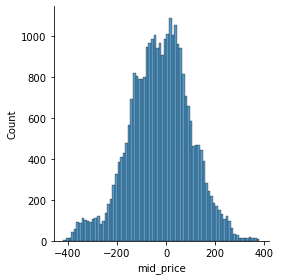

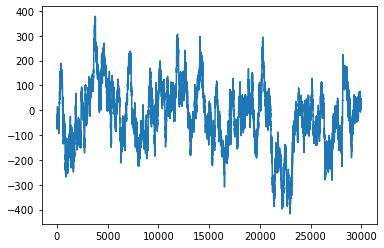

In [19]:
display(price_arb.describe())
sns.displot(price_arb['mid_price'], height=4)
f,ax = plt.subplots()
price_arb['mid_price'].plot(ax=ax)

,mid_price,timestamp,day
count,10000.000000,1.000000e+04,10000.0
mean,-74.727650,2.499950e+06,3.0
std,133.155491,2.886896e+05,0.0
min,-417.500000,2.000000e+06,3.0
25%,-162.500000,2.249975e+06,3.0
50%,-57.500000,2.499950e+06,3.0
75%,17.500000,2.749925e+06,3.0
max,295.000000,2.999900e+06,3.0


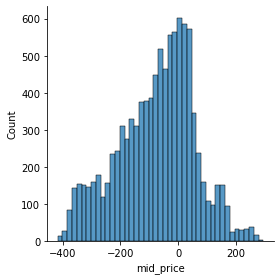

In [20]:
display(price_arb.loc[price_arb.day == 3].describe())
sns.displot(x='mid_price', data=price_arb.loc[price_arb.day == 3], height=4)

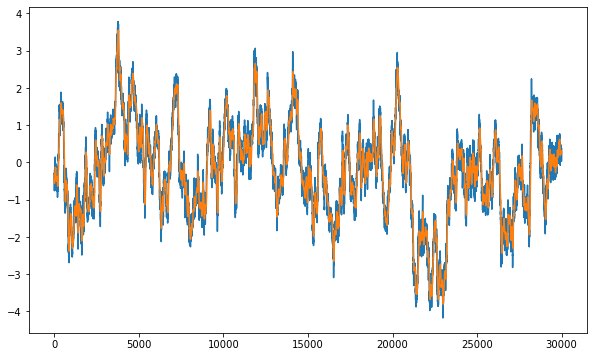

In [22]:
f, ax = plt.subplots(figsize=(10,6))
ax.plot(zscore)
ax.plot(zscore.ewm(com=20,min_periods=0).mean())

In [25]:
def align_yaxis(ax1, ax2):
    y_lims = np.array([ax.get_ylim() for ax in [ax1, ax2]])

    # force 0 to appear on both axes, comment if don't need
    y_lims[:, 0] = y_lims[:, 0].clip(None, 0)
    y_lims[:, 1] = y_lims[:, 1].clip(0, None)

    # normalize both axes
    y_mags = (y_lims[:,1] - y_lims[:,0]).reshape(len(y_lims),1)
    y_lims_normalized = y_lims / y_mags

    # find combined range
    y_new_lims_normalized = np.array([np.min(y_lims_normalized), np.max(y_lims_normalized)])

    # denormalize combined range to get new axes
    new_lim1, new_lim2 = y_new_lims_normalized * y_mags
    ax1.set_ylim(new_lim1)
    ax2.set_ylim(new_lim2)

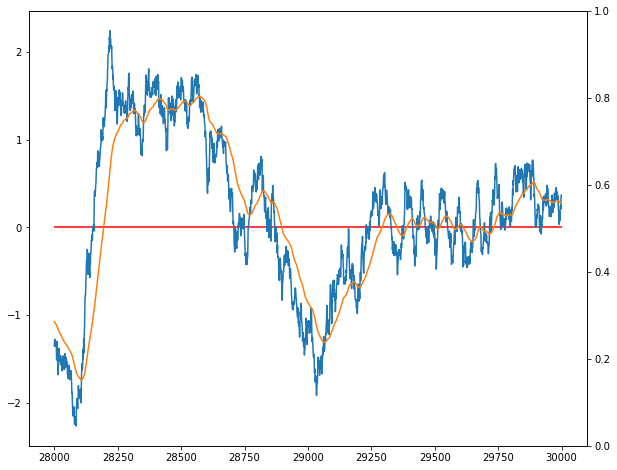

In [137]:
f, ax = plt.subplots(1, figsize=(10,8))
action_signal = zscore.ewm(com=50,min_periods=0).mean()
# action_signal = zscore.loc[np.abs(action_signal) < 0.01]
start, end = 28000, 30000
# action_signal = action_signal*np.sign(zscore)
# action_signal = action_signal.rolling(100,min_periods=0).mean()
ax = [ax, ax.twinx()]
ax[0].plot(zscore[start:end])
ax[0].plot(action_signal[start:end])

ax[0].hlines(y=0, xmin=start, xmax=end,color='red')
# 
# ax[1].plot(action_signal.loc[start:end],color='orange', marker='.',linestyle = 'None')
# align_yaxis(ax[0], ax[1])

# Code Testing

In [203]:
POSITION_LIMITS = {
    "PEARLS": 20,
    "BANANAS": 20,
    "COCONUTS": 600,
    "PINA_COLADAS": 300,
    "DIVING_GEAR": 50,
    "BERRIES": 250,
    "BAGUETTE": 150,
    "DIP": 300,
    "UKULELE": 70,
    "PICNIC_BASKET": 70,
}
BASKET_COMPONENTS = ['PICNIC_BASKET','DIP','BAGUETTE','UKULELE']


In [204]:
def get_basket_positions(px_signal, curr_pos):
    """
    Positive side means buy basket
    Positions will be returned as absolute values
    """
    side = np.sign(px_signal)
    abs_signal = abs(px_signal)
    
    target_pos = curr_pos.copy()

    # Maximum position at 2
    entry = 1
    exit = 0.25

    curr_rel_pos = [0,0,0,0]
    for i in range(4):
        # Get absolute relative positions
        curr_rel_pos[i] = -side*curr_pos[i]/BASKET_WEIGHTS[i]

    if abs_signal > entry:
        target_min = math.floor((abs_signal-entry)*35)
        target_min = min(target_min, POSITION_LIMITS['PICNIC_BASKET'])
        # Adjust for previous high signals
        target_min = max(max(curr_rel_pos),target_min)
        target_pos = [-side*round(target_min*BASKET_WEIGHTS[i]) for i in range(4)]

        target_pos = [-side*target_min*BASKET_WEIGHTS[i] for i in range(4)]

    if abs_signal < exit:
        target_pos = [0,0,0,0]
        side = -np.sign(curr_pos[0])

    for i in range(4):
        # Ensure that position is valid
        target_pos[i] = min(abs(target_pos[i]), POSITION_LIMITS[BASKET_COMPONENTS[i]])*np.sign(target_pos[i])

    return target_pos, side

In [206]:
initial_position = [0,0,0,0]
curr_position,side = get_basket_positions(-2, initial_position)
print(curr_position, side)

curr_position,side = get_basket_positions(-2.5, curr_position)
print(curr_position, side)

curr_position[1] += 15

curr_position,side = get_basket_positions(-2, curr_position)
print(curr_position, side)

curr_position,side = get_basket_positions(3, curr_position)
print(curr_position, side)

curr_position,side = get_basket_positions(0, curr_position)
print(curr_position, side)

[-35, 140, 70, 35] -1
[-52.0, 208.0, 104.0, 52.0] -1.0
[-55.75, 223.0, 111.5, 55.75] -1
[70, -280, -140, -70] 1
[0, 0, 0, 0] -1


# Backtest Analysis

In [40]:
def read_trading_logs(file):
    # Load in jsons for trading states and sent orders
    state_regex = re.compile(r"(\d+) (\{.*\})$")
    orders_regex = re.compile(r"(\d+) SENT_ORDERS (\{.*\})")

    trading_states = []
    sent_orders = []
    with open(file, "r") as fp:
        lines = fp.readlines()
        for l in lines:
            match = state_regex.match(l)
            if match:
                trading_states.append(match.group(2))
                continue
            match = orders_regex.match(l)
            if match:
                sent = json.loads(match.group(2))
                sent['timestamp'] = int(match.group(1))
                sent_orders.append(sent)
                continue
        
    return trading_states, sent_orders

def process_trading_state_jsons(trading_states):
    positions = []
    market_trades = []
    latest_trade_timestamp = collections.defaultdict(int)
    own_trades = []
    order_depths = []
    observations = []
    
    listings = json.loads(trading_states[0])["listings"]
    for l in listings:
        # Dummy position
        positions.append({"timestamp": 0, "symbol": l, "position": 0})
    
    for t in trading_states:
        state = json.loads(t)
        if type(state) == int:
            insert_empty_state(state, listings, positions)
        else:
            extract_position(positions, state)
            extract_new_trades(market_trades, latest_trade_timestamp, state)
            extract_own_trades(own_trades, state)
            extract_order_book(order_depths, state)
            extract_observations(observations, state)
            
    positions = pd.DataFrame(positions)
    observations = pd.DataFrame(observations)
    
    market_trades = pd.DataFrame(market_trades)
    if len(own_trades) == 0:
        own_trades.append({"timestamp": -1, "symbol": l, "price": np.nan, "quantity": 0, "buyer": "DUMMY", "seller": 0})
    own_trades = pd.DataFrame(own_trades)
    order_depths = pd.DataFrame(order_depths)
    
    return positions, market_trades, own_trades, order_depths, observations

def insert_empty_state(timestamp, listings, *args):
    # Insert timestamp corresponding to the empty state - these are to be forward filled
    for data in args:
        for l in listings:
            data.append({"timestamp": timestamp, "symbol": l})
    return

def extract_position(positions, state):
    pos = state['position']
    for p in pos:
        positions.append({"timestamp": state['timestamp'], "symbol": p, "position": pos[p]})
    for p in SYMBOLS:
        if p not in pos:
            positions.append({"timestamp": state['timestamp'], "symbol": p, "position": 0})
    return

def extract_observations(observations, state):
    obs = state['observations']
    for p in obs:
        observations.append({"timestamp": state['timestamp'], "symbol": p, "observation": obs[p]})
        
    return

def extract_new_trades(market_trades, latest_trade_timestamp, state):
    time = state['timestamp']
    for sym in state['market_trades']:
        for t in state['market_trades'][sym]:
            if t['timestamp'] == time-100:
                market_trades.append(t)
            elif t['timestamp'] == time:
                print("Found same timestamp trade")
    return

def extract_own_trades(own_trades, state):
    time = state['timestamp']
    for sym in state['own_trades']:
        for t in state['own_trades'][sym]:
            if t['timestamp'] == time-100:
                own_trades.append(t)
            elif t['timestamp'] == time:
                print("Found same timestamp trade")
    return

def extract_order_book(order_depths, state):
    time = state['timestamp']
    for sym in state['order_depths']:
        quote = create_quote(time, sym, state['order_depths'][sym])
        order_depths.append(quote)
    return


def create_quote(time, sym, order_depths):
    quote = {'timestamp': time, 'symbol': sym}
    
    # Buy quotes
    quote['bid_levels'] = len(order_depths['buy_orders'])
    for i, px in enumerate(sorted(order_depths['buy_orders'], key=lambda x: float(x), reverse=True)):
        # Highest to lowest
        quote[f'bid_{i+1}'] = float(px)
        quote[f'bid_sz_{i+1}'] = order_depths["buy_orders"][px]
    for i in range(5, 1, -1):
        if f'bid_{i}' in quote:
            break
        else:
            quote[f'bid_{i}'] = np.nan
            quote[f'bid_sz_{i}'] = np.nan
    
    # Sell quotes
    quote['ask_levels'] = len(order_depths['sell_orders'])
    for i, px in enumerate(sorted(order_depths['sell_orders'], key=lambda x: float(x))):
        quote[f'ask_{i+1}'] = float(px)
        quote[f'ask_sz_{i+1}'] = np.abs(order_depths["sell_orders"][px])
    for i in range(5, 1, -1):
        if f'ask_{i}' in quote:
            break
        else:
            quote[f'ask_{i}'] = np.nan
            quote[f'ask_sz_{i}'] = np.nan
        
    return quote

def process_order_depths(order_depths):
    order_depths.rename(columns={'bid_1': 'bid', 'ask_1': 'ask', 'bid_sz_1': 'bid_sz', 'ask_sz_1': 'ask_sz'}, inplace=True)
    order_depths['mid_price'] = (order_depths['bid']+order_depths['ask'])/2
    nbbo = order_depths[['timestamp','symbol','bid','ask','bid_sz','ask_sz', 'mid_price']].copy()

    return nbbo

def process_market_trades(market_trades):
    """ Processing of dataframe for market_trades
    """
    market_trades.drop(columns=['buyer', 'seller'], inplace=True)
    return

def process_own_trades(own_trades):
    """ Processing of dataframe for own_trades
    """ 
    # Side refers to side of algo
    own_trades['side'] = own_trades.apply(lambda x: 1 if x['buyer'] else -1, axis=1)
    own_trades.drop(columns=['buyer', 'seller'], inplace=True)
    return

def process_sent_orders_json(sent_orders):
    if len(sent_orders) == 0:
        return pd.DataFrame(columns = ['symbol', 'timestamp', 'price', 'quantity', 'side'])
    df = []
    for t in sent_orders:
        time = t['timestamp']
        for s in t:
            if s != 'timestamp' and t[s]:
                for order in t[s]:
                    order['timestamp'] = time
                    df.append(order)
        
    df = pd.DataFrame(df)
    return df


def combine_quote_trades(quote, trades):
    # Aggregate timestamp data of trades
    trades['notional'] = trades['price']*trades['quantity']
    # trades['buy_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == 1 else 0, axis=1)
    # trades['sell_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == -1 else 0, axis=1)
    # trades['grey_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == 0 else 0, axis=1)
    
    # Trades are aligned to happen after the order depth that we see in the market
    trades['timestamp'] = trades['timestamp'] + 100
    trades_grouped = trades.groupby(['symbol', 'timestamp']).agg({'quantity':'sum', 'notional':'sum'})
    trades_grouped['vwap'] = trades_grouped['notional']/trades_grouped['quantity']
    trades_grouped['trades'] = trades.groupby(['symbol', 'timestamp']).size()
    
    trades_grouped = trades_grouped.rename(columns={'quantity':'volume'})
    quote = quote.merge(trades_grouped.reset_index(), how='left')
    for col in ['volume', 'notional','trades']:
        quote[col].fillna(0, inplace=True)
    
    quote.loc[quote.vwap.isna(), 'vwap'] = quote.loc[quote.vwap.isna(), 'mid_price']
    return quote

def combine_quote_algo_trades(quote, trades):
    # Aggregate timestamp data of trades
    trades['notional'] = trades['price']*trades['quantity']
    
    # Trades are aligned to happen after the order depth that we see in the market
    trades['timestamp'] = trades['timestamp'] + 100
    trades_grouped = trades.groupby(['symbol', 'timestamp']).agg({'quantity':'sum', 'notional':'sum'})
    trades_grouped['trades'] = trades.groupby(['symbol', 'timestamp']).size()
    
    trades_grouped = trades_grouped.rename(columns={'quantity':'volume'})
    quote = quote.merge(trades_grouped.reset_index(), on=['symbol','timestamp'], how='left', suffixes=('','_algo'))
    
    for col in ['volume_algo', 'notional_algo', 'trades_algo']:
        quote[col].fillna(0, inplace=True)
    
    return quote

def fill_active(x):
    if x['side'] == 1:
        # Buy
        return x['price'] >= x['ask']
    else:
        return x['price'] <= x['bid']
    
def fix_fill_volume(x):
    fill_qty = np.clip(x['fill_qty']-x['quantity'].cumsum()-x['quantity'].iat[0], 0, None)
    return fill_qty

def combine_orders_fills(orders, fills):
    """ Combine orders sent with fills that the order got in the market
    """
    if orders.empty:
        return orders
    fills['active'] = fills.apply(fill_active, axis=1)

    gcols = ['symbol','timestamp','price','side']
    fill_data = fills.groupby(gcols)[['quantity']].sum()
    fill_data.reset_index(inplace=True)
    fill_data.rename(columns={'quantity': 'fill_qty'}, inplace=True)
    fill_data['i'] = 0
    orders['i'] = orders.groupby(gcols).cumcount()
    orders = orders.merge(fill_data, how='left', on=gcols+['i']).drop('i',axis=1)
    orders['fill_qty'].fillna(0, inplace=True)    
    orders['fill_pct'] = np.abs(orders['fill_qty']/orders['quantity'])
    
    return orders

# PnL, Position, Volume Traded, Notional Traded, VWAP
def trading_performance(positions, own_trades, quote):
    positions = positions.merge(quote[['timestamp','symbol','mid_price']], on=['symbol','timestamp']) # Add mid price
    own_trades['trades'] = 1
    own_trades['notional'] = own_trades['price']*own_trades['quantity']
    own_trades.rename(columns={'quantity':'qty'},inplace=True)
    vol_cols = []
    for col in ['qty','notional','trades']:
        own_trades[f'buy_{col}'] = own_trades[col]
        own_trades[f'sell_{col}'] = own_trades[col]
        own_trades.loc[own_trades['side'] == -1, f'buy_{col}'] = 0
        own_trades.loc[own_trades['side'] == 1, f'sell_{col}'] = 0
        vol_cols += [col, f'buy_{col}',f'sell_{col}']
    own_trades_g = own_trades.groupby(['symbol','timestamp'])[vol_cols].sum()

    positions = positions.merge(own_trades_g.reset_index(), how='left', on=['symbol','timestamp'])
    for col in vol_cols:
        positions[col].fillna(0, inplace=True)
        positions[f'total_{col}'] = positions.groupby('symbol')[col].transform(pd.Series.cumsum)
    positions['pnl'] = (positions['total_sell_notional']-positions['total_buy_notional']) \
            - positions['mid_price']*(positions['total_sell_qty']-positions['total_buy_qty'])

    positions = positions.copy()
    return positions

def load_data_from_log(file, by_symbol=True):
    trading_states, sent_orders = read_trading_logs(file)
    positions, market_trades, own_trades, order_depths, observations = process_trading_state_jsons(trading_states)
    quote = process_order_depths(order_depths)
    process_market_trades(market_trades)
    process_own_trades(own_trades)
    orders = process_sent_orders_json(sent_orders)
    
    # Joining actions to state
    market_trades = market_trades.merge(quote, how='left', on=['symbol','timestamp',])
    augment_trade_data(market_trades)
    
    own_trades = own_trades.merge(quote, how='left', on=['symbol','timestamp','symbol'])
    orders = orders.merge(quote, how='left', on=['symbol','timestamp'])
    orders = combine_orders_fills(orders, own_trades)
    
    quote = combine_quote_trades(quote, market_trades.copy())
    quote = combine_quote_algo_trades(quote, own_trades.copy())

    order_depths = combine_quote_trades(order_depths, market_trades.copy())
    order_depths = combine_quote_algo_trades(order_depths, own_trades.copy())
    
    positions = trading_performance(positions, own_trades.copy(), quote) 
    
    dfs = {}
    dfs['orders'] = orders
    dfs['positions'] = positions
    dfs['order_depths'] = order_depths
    dfs['quote'] = quote
    dfs['market_trades'] = market_trades
    dfs['own_trades'] = own_trades
    dfs['observations'] = observations
    
    if by_symbol:
        for table in dfs:
            if not dfs[table].empty:
                dfs[table] = split_data_by_symbol(dfs[table])    
    return dfs

In [41]:
def plot_intraday(dfs, col):
    f, ax = plt.subplots(figsize=fig_size)
    for product in dfs:
        ax.plot("timestamp", col, data=dfs[product], label=product)
    ax.set_xlabel("Time")
    ax.set_ylabel(col)
    ax.legend()
    plt.tight_layout()
    
    return

def trading_simulation_summary(dfs):
    total_pnl = 0
    for sym in SYMBOLS:
        trade_perf = dfs['positions'][sym].iloc[-1]
        pnl = trade_perf['pnl']
        total_pnl += pnl
        market_volume = dfs['market_trades'][sym]['quantity'].sum()
        trade_count = trade_perf['total_trades']
        trade_volume = trade_perf['total_qty']
        vol_per_step = dfs['positions'][sym]['qty'].mean()

        print("""{}: PnL={} | Trades={} | MarketVol={} | Volume Filled={} | POV={:.2} | Shares/Step={:.3} | PnL/Share={:.4}""".format(sym, \
            pnl, trade_count, market_volume, trade_volume,trade_volume/(market_volume+trade_volume), vol_per_step, pnl/trade_volume))
    print("Total PnL={}".format(total_pnl))
    plot_intraday(dfs['positions'], 'pnl')
    plot_intraday(dfs['positions'], 'position')

In [42]:
def algo_spread(x):
    bid = np.fmax(x['price_algo_buy'], x['bid'])
    ask = np.fmin(x['price_algo_sell'], x['ask'])
    return ask-bid

algo_market_cols = ['symbol', 'timestamp', 'price_algo_buy', 'price_algo_sell','algo_spread']
def get_algo_market(orders, quote):
    buy_orders = orders.loc[orders.side == 1].copy()
    sell_orders = orders.loc[orders.side == -1].copy()

    buy_spread = buy_orders.groupby(['symbol','timestamp','price']).agg({'quantity':'sum','fill_qty':'sum'}).reset_index()
    buy_spread.drop_duplicates(subset=['symbol','timestamp'], inplace=True, keep='last') # keep most aggressive
    sell_spread = sell_orders.groupby(['symbol','timestamp','price']).agg({'quantity':'sum','fill_qty':'sum'}).reset_index()
    sell_spread.drop_duplicates(subset=['symbol','timestamp'], inplace=True, keep='first')
    
    algo_market = buy_spread.merge(sell_spread, how='outer', on=['symbol','timestamp'], suffixes=['_algo_buy','_algo_sell'])
    algo_market.sort_values('timestamp',inplace=True)
    algo_market = algo_market.merge(quote, how='left', on=['symbol','timestamp'])
    algo_market['spread'] = algo_market['ask'] - algo_market['bid']
    algo_market['algo_spread'] = algo_market.apply(algo_spread, axis=1)
    
    return algo_market

def order_analysis(orders):
    orders['px_bid_dist'] = orders['price'] - orders['bid']
    orders['px_ask_dist'] = orders['price'] - orders['ask']
    orders['filled'] = orders['fill_qty'] > 0
    
    for t in FUTURE_TIMES:
        orders[f'toxicity_{t}'] = orders['side']*(orders[f'fpx_{t}']+orders['mid_price']-orders['price'])
        orders[f'pnl_{t}'] = orders['fill_qty']*orders[f'toxicity_{t}']
        orders[f'fill_revert_{t}'] = np.sign(orders[f'pnl_{t}'])
        orders[f'spread_capture_{t}'] = orders[f'toxicity_{t}']/orders['spread']
    
    return

toxicity_labels, reversion_labels = [], []
for t in FUTURE_TIMES:
    toxicity_labels.append(f'toxicity_{t}')
    reversion_labels.append(f'fill_revert_{t}')

def get_orders_fills(market_trades, orders, quote):
    algo_market = get_algo_market(orders, quote)

    orders_cols = ['note', 'price', 'quantity', 'side', 'symbol', 'timestamp','fill_qty']
    fills = orders.loc[orders.fill_qty > 0]
    fills = fills.merge(quote_preprocess(quote), how='left',on=['symbol','timestamp'], suffixes=('','_q'))
    order_analysis(fills)
    fills = fills.merge(algo_market[algo_market_cols], on=['symbol','timestamp'])

    missed_fills = orders[orders_cols].merge(market_trades, on=['symbol','timestamp'], suffixes=('_algo','_mkt'))
    missed_fills = missed_fills.merge(quote_preprocess(quote), how='left',on=['symbol','timestamp'], suffixes=('','_q'))
    missed_fills = missed_fills.merge(algo_market[algo_market_cols], on=['symbol','timestamp'])
    
    return fills, missed_fills

## Load

PICNIC_BASKET: PnL=100580.0 | Trades=247.0 | MarketVol=1725 | Volume Filled=878.0 | POV=0.34 | Shares/Step=0.0878 | PnL/Share=114.6
DIP: PnL=-13845.0 | Trades=132.0 | MarketVol=8067 | Volume Filled=3568.0 | POV=0.31 | Shares/Step=0.357 | PnL/Share=-3.88
BAGUETTE: PnL=6545.0 | Trades=136.0 | MarketVol=5494 | Volume Filled=1784.0 | POV=0.25 | Shares/Step=0.178 | PnL/Share=3.669
UKULELE: PnL=-18813.0 | Trades=131.0 | MarketVol=3403 | Volume Filled=892.0 | POV=0.21 | Shares/Step=0.0892 | PnL/Share=-21.09
Total PnL=74467.0


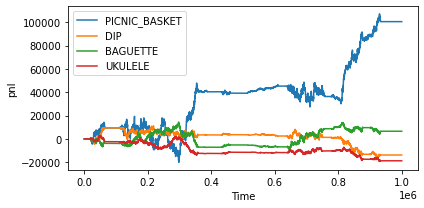

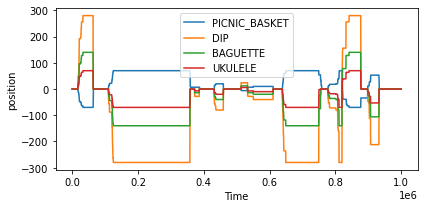

In [61]:
log_file = "backtest_logs/backtest.log"

dfs = load_data_from_log(log_file, True)
trading_simulation_summary(dfs)

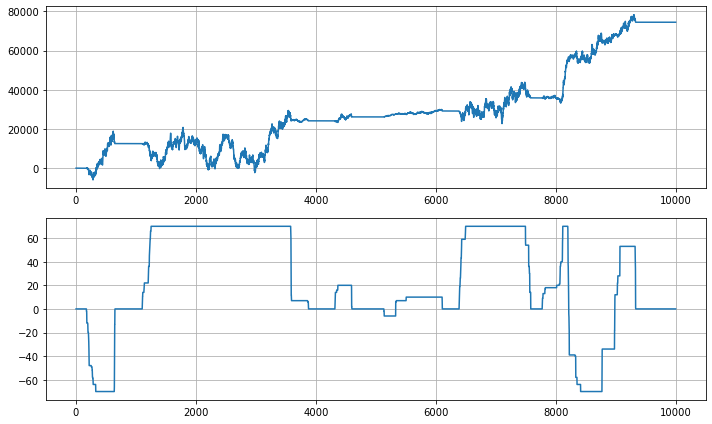

In [62]:
f, ax = plt.subplots(2, figsize=(10,6))
basket_pnl = 0
for sym in SYMBOLS:
    basket_pnl += dfs['positions'][sym]['pnl']
ax[0].plot(basket_pnl)
ax[0].grid()
ax[1].plot(dfs['positions']['PICNIC_BASKET']['position'])
ax[1].grid()
plt.tight_layout()

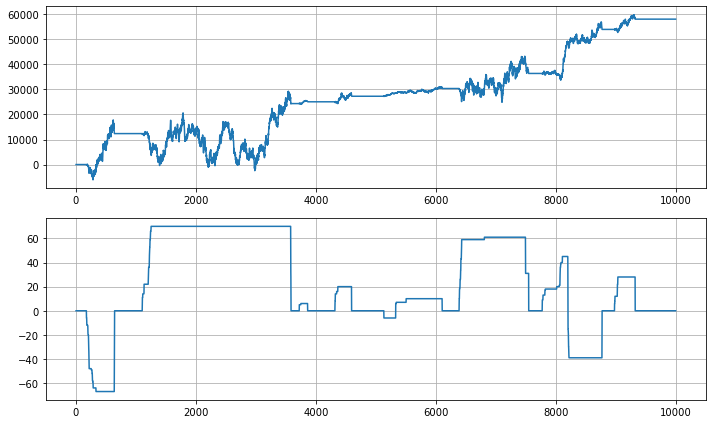

In [136]:
f, ax = plt.subplots(2, figsize=(10,6))
basket_pnl = 0
for sym in SYMBOLS:
    basket_pnl += dfs['positions'][sym]['pnl']
ax[0].plot(basket_pnl)
ax[0].grid()
ax[1].plot(dfs['positions']['PICNIC_BASKET']['position'])
ax[1].grid()
plt.tight_layout()